# Financial transactions
This is the notebook of the whole process on how we found and trained our model, preprocessed our data and tested our model.

If you just want to evaluate the final chosen model exectute every step after the chapter [Train final algorithm](#final-algorithm). This is also where the training script is.

Note: there are additional libraries used for plotting but they are not important to test the final algorithm. Only to understand how we determined the best preprocessing method for our data.

In [1]:
import os
# data
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# math
import numpy as np

# sklearn
from sklearn import metrics
from sklearn.utils import resample

# display
from IPython.display import display

## Helper functions

these are some functions that will help us visualise and plot data

In [2]:
# Print confusion matrix
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)'])

def plot_specificity_sensitivity(model_names, confusion_matrices):
    num_models = len(model_names)

    # Calculate sensitivity and specificity for each model
    tpr_values = []
    tnr_values = []

    for cm in confusion_matrices:
        tn, fp, fn, tp = cm.ravel()

        tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
        fnr = fn / (fn + tp)  # False Negative Rate (Miss Rate)
        tpr = tp / (tp + fn)  # True Positive Rate (Sensitivity/Recall)

        tpr_values.append(tpr)
        tnr_values.append(tnr)

    # Plotting Sensitivity and Specificity
    fig, ax = plt.subplots(figsize=(8, 6))

    index = np.arange(num_models)
    bar_width = 0.35
    opacity = 0.8

    rects1 = ax.bar(index, tpr_values, bar_width, alpha=opacity, color='red', label='Sensitivity')
    rects2 = ax.bar(index + bar_width, tnr_values, bar_width, alpha=opacity, color='blue', label='Specificity')

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison - Sensitivity and Specificity')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(model_names)
    ax.legend()

    # Add labels to each bar
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

def plot_scores(model_names, scores, name):
    min_score = min(scores)
    y_min = min_score - 0.01
    y_max = 1.0
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(model_names, scores)

    ax.set_ylim([y_min, y_max])

    ax.set_title('Model Comparison - ' + name)
    ax.set_xlabel('Model')
    ax.set_ylabel(name)

    plt.xticks(rotation=45)

    plt.show()

## Analyse the data

Importing the data from the given csv sheet using pandas and analysing it's structure


In [3]:
# Import data
path = "./data" if os.path.exists("./data") else "."
data = pd.read_csv(os.path.join(path, "transactions.csv"))
# split the data columns:
X = data.drop("Class", axis=1)
y = data["Class"]
X_data = X.values
y_data = y.values
print(X_data.shape)
print(data.columns)


(227845, 30)
Index(['Time', 'Feature0', 'Feature1', 'Feature2', 'Feature3', 'Feature4',
       'Feature5', 'Feature6', 'Feature7', 'Feature8', 'Feature9', 'Feature10',
       'Feature11', 'Feature12', 'Feature13', 'Feature14', 'Feature15',
       'Feature16', 'Feature17', 'Feature18', 'Feature19', 'Feature20',
       'Feature21', 'Feature22', 'Feature23', 'Feature24', 'Feature25',
       'Feature26', 'Feature27', 'Amount', 'Class'],
      dtype='object')


### Correlation heatmap
Analyse the correlation in the data to find out if we can toss any columns

<Axes: >

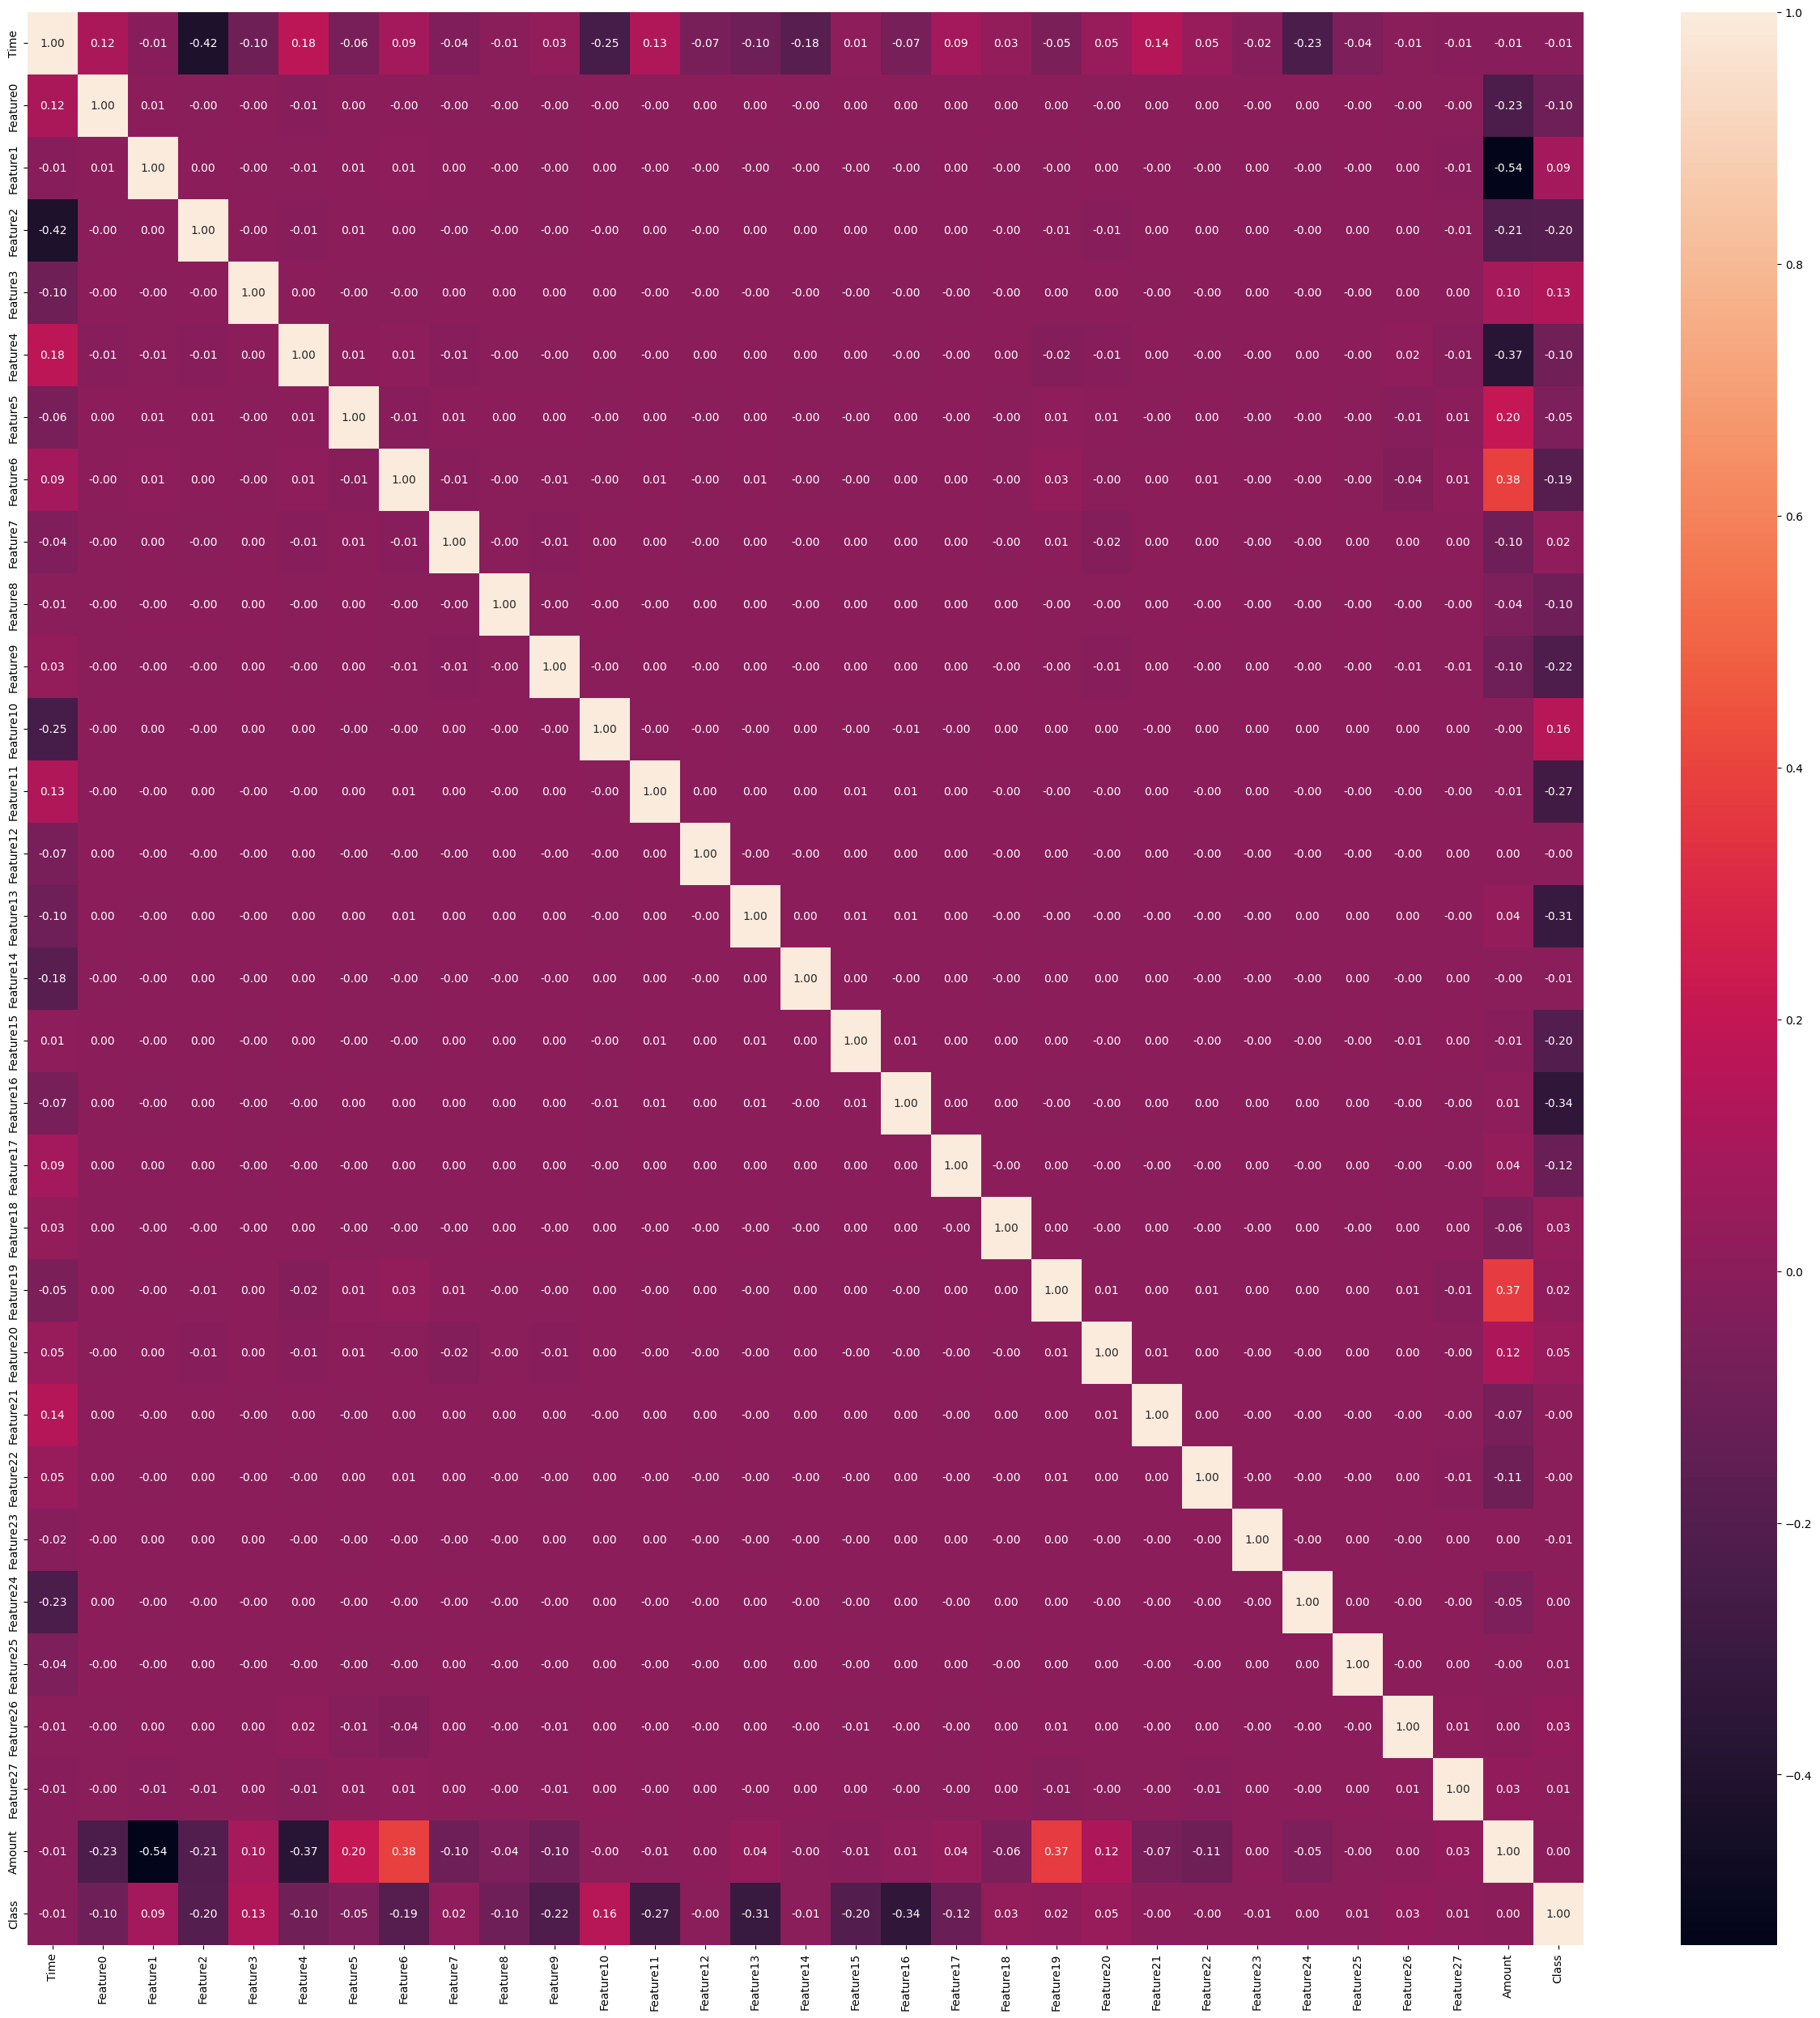

In [5]:
# find out about correlation and if we can eliminate some columns if they have high correlataion
plt.figure(figsize=(31,31))
sns.heatmap(data.corr(), annot=True, fmt='.2f')

As can be seen from this heatmap, the columns in the data show no significant correlation

### Dataset Balance

Find out how balanced the training data is by counting the number of entries corresponding to each label

In [6]:
count_classes = y.value_counts()
print(count_classes)

Class
0    227451
1       394
Name: count, dtype: int64


This dataset is highly imbalanced so we need to find a way to make this better for training.

We oversample positive examples which are underrepresented in our data and plot the correlation in order to see if we produce data that is too unreliable.

Class
0    227451
1    227451
Name: count, dtype: int64


<Axes: >

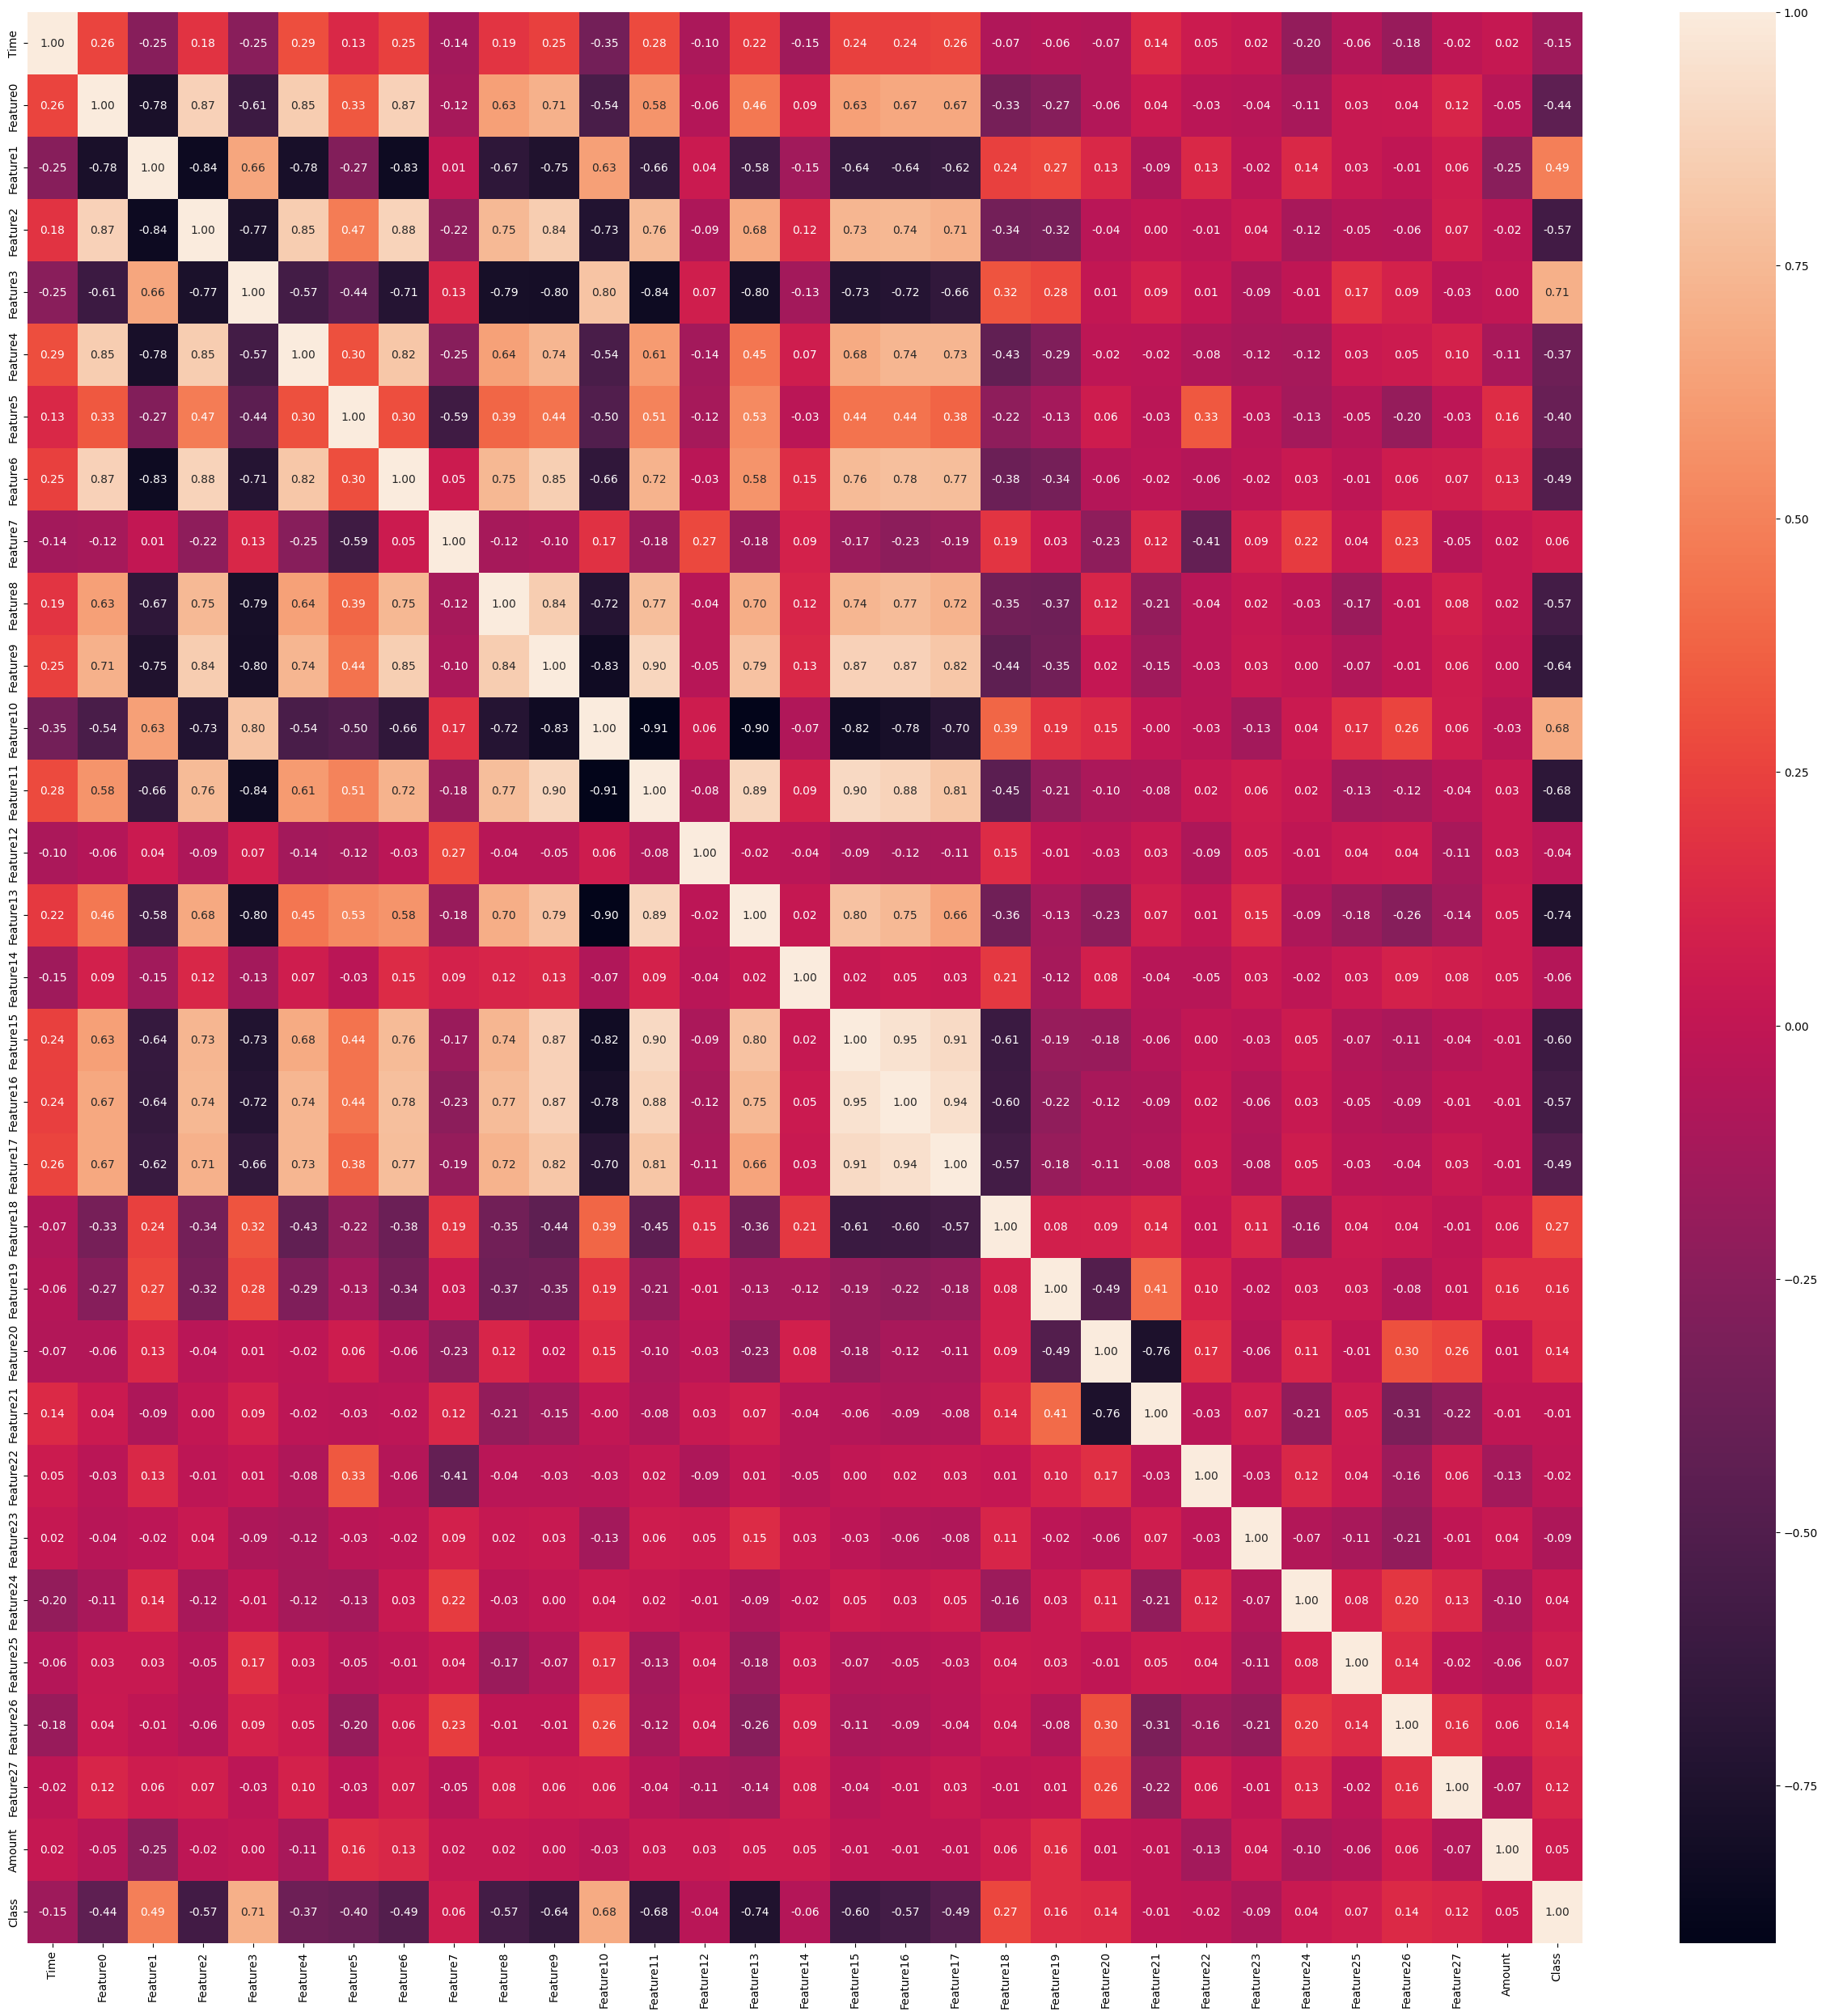

In [4]:
X_oversampled, y_oversampled = resample(X_data[y_data == 1], y_data[y_data == 1], replace=True, n_samples=X_data[y_data == 0].shape[0], random_state=42)

X_balanced = np.vstack((X_data[y_data == 0], X_oversampled))
y_balanced = np.hstack((y_data[y_data == 0], y_oversampled))

cols_without_class = data.columns.drop('Class')
new_X_df = pd.DataFrame(X_balanced, columns=cols_without_class)
new_y_df = pd.DataFrame(y_balanced, columns=['Class'])

balanced_data = pd.concat([new_X_df, new_y_df], axis=1)
print(balanced_data.value_counts('Class'))


plt.figure(figsize=(31,31))
sns.heatmap(balanced_data.corr(), annot=True, fmt='.2f')

## Selecting a model

For a classification problem like this we have a variety of models to choose from like **Neural networks**, **Desicion trees**, **Random forests**, **Logicstic regression**, ...

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

# Define models and parameter grids
algorithms = [
    (
        "Logistic Regression",
        LogisticRegression(),
        {
            "penalty": ["l2"],
            "C": [0.001, 0.01, 0.1, 1, 10, 100],
            "class_weight": ["balanced", None, {0: 0.1, 1: 0.9}],
        }
    ),
    (
        "Decision Tree",
        DecisionTreeClassifier(),
        {
            "criterion": ["gini"],
            "max_depth": range(5,15,1),
            "min_samples_split": range(2,10,2),
            "max_features": ['sqrt', 'log2', None],
            "splitter": ["best", "random"],
            "class_weight": ["balanced", None, {0: 0.3, 1: 0.7}, {0: 0.1, 1: 0.9}],
        },
    ),
    (
        "Random Forest",
        RandomForestClassifier(),
        {
            "n_estimators": [100, 200],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5, 10],
            "class_weight": ["balanced", None, {0: 0.1, 1: 0.9}],
        },
    ),
    (
        "Neural Network",
        MLPClassifier(learning_rate_init=0.001),
        {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001, 0.01],
        },
    ),
    (
        "AdaBoost",
        AdaBoostClassifier(random_state=0),
        {
            "n_estimators": [50,100],
            "estimator": [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
        }
    )
]

### The training algorithm

In [6]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

def train_model(name, model, param_grid, X_train, y_train, X_test, y_test):
    print(f"Estimating hyperparameters for {name}, using param grid {param_grid} ...")

    # Estimate hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring="roc_auc", cv=n_fold, verbose=5)
    grid_search.fit(X_train, y_train)

    # Get the grid search results
    results = grid_search.cv_results_
    print(results)

    best_parameters = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"{name}")
    print(f"Best params: {best_parameters}, Best score: {best_score}")

    model.set_params(**best_parameters)

    print("Fitting models with best parameters...")
    model.fit(X_train, y_train)

    print(f'Fitted Model Parameters: {model.get_params()}\n')

    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"ROC AUC on testing data: {score:.4f}\n")
    print(f"Accuracy on testing data: {accuracy:.4f}\n")

    cm = confusion_matrix(y_test, y_pred)
    ((tn, fp), (fn, tp)) = confusion_matrix(y_test, y_pred)
    ((tnr,fpr),(fnr,tpr))= confusion_matrix(y_test, y_pred, 
            normalize='true')
    display(pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)']))
    return accuracy, score, cm


Use n-fold cross validation and prepare data:

Note: if you're executing some of the following training scripts, it could take hours to complete since parameters are searched with grid search.  
Quicker examples are Logistric regression and Decision tree.

In [8]:
n_fold = 4

model_scores = []

log_reg = algorithms[0]
des_tree = algorithms[1]
rand_for = algorithms[2]
mlp = algorithms[3]
ada = algorithms[4]

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2,
                                                    random_state=1, stratify=y_balanced)


### Logistic regression

In [44]:
# Train logistic regression
l_n, l_m, l_p_g = log_reg
log_reg_acc, log_reg_roc, log_reg_cm = train_model(l_n, l_m, l_p_g, X_train, y_train, X_test, y_test)

Estimating hyperparameters for Logistic Regression, using param grid {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': ['balanced', None, {0: 0.1, 1: 0.9}]} ...
Fitting 4 folds for each of 18 candidates, totalling 72 fits


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END C=0.001, class_weight=balanced, penalty=l2;, score=0.977 total time=   2.8s
[CV 2/4] END C=0.001, class_weight=balanced, penalty=l2;, score=0.981 total time=   3.0s
[CV 3/4] END C=0.001, class_weight=balanced, penalty=l2;, score=0.982 total time=   2.5s
[CV 4/4] END C=0.001, class_weight=balanced, penalty=l2;, score=0.975 total time=   2.0s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END C=0.001, class_weight=None, penalty=l2;, score=0.977 total time=   2.8s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END C=0.001, class_weight=None, penalty=l2;, score=0.981 total time=   2.4s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END C=0.001, class_weight=None, penalty=l2;, score=0.979 total time=   2.5s
[CV 4/4] END C=0.001, class_weight=None, penalty=l2;, score=0.975 total time=   2.2s
[CV 1/4] END C=0.001, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.1s
[CV 2/4] END C=0.001, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.971 total time=   1.3s
[CV 3/4] END C=0.001, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.4s
[CV 4/4] END C=0.001, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.1s
[CV 1/4] END C=0.01, class_weight=balanced, penalty=l2;, score=0.956 total time=   1.4s
[CV 2/4] END C=0.01, class_weight=balanced, penalty=l2;, score=0.975 total time=   1.9s
[CV 3/4] END C=0.01, class_weight=balanced, penalty=l2;, score=0.956 total time=   1.5s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END C=0.01, class_weight=balanced, penalty=l2;, score=0.982 total time=   2.6s
[CV 1/4] END C=0.01, class_weight=None, penalty=l2;, score=0.956 total time=   1.4s
[CV 2/4] END C=0.01, class_weight=None, penalty=l2;, score=0.975 total time=   2.2s
[CV 3/4] END C=0.01, class_weight=None, penalty=l2;, score=0.956 total time=   1.4s
[CV 4/4] END C=0.01, class_weight=None, penalty=l2;, score=0.976 total time=   2.2s
[CV 1/4] END C=0.01, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.5s
[CV 2/4] END C=0.01, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.971 total time=   1.5s
[CV 3/4] END C=0.01, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.4s
[CV 4/4] END C=0.01, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.5s
[CV 1/4] END C=0.1, class_weight=balanced, penalty=l2;, score=0.956 total time=   1.3s
[CV 2/4] END C=0.1, class_weight=balanced, penalty=l2;, score=0.975 total time=   2.0s
[CV 3/4] END C=0.1

/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END C=0.1, class_weight=None, penalty=l2;, score=0.976 total time=   2.6s
[CV 1/4] END C=0.1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.1s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END C=0.1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.986 total time=   3.4s
[CV 3/4] END C=0.1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.7s
[CV 4/4] END C=0.1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.980 total time=   2.6s
[CV 1/4] END C=1, class_weight=balanced, penalty=l2;, score=0.956 total time=   1.5s
[CV 2/4] END C=1, class_weight=balanced, penalty=l2;, score=0.975 total time=   2.0s
[CV 3/4] END C=1, class_weight=balanced, penalty=l2;, score=0.957 total time=   1.4s
[CV 4/4] END C=1, class_weight=balanced, penalty=l2;, score=0.976 total time=   2.4s
[CV 1/4] END C=1, class_weight=None, penalty=l2;, score=0.956 total time=   1.3s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END C=1, class_weight=None, penalty=l2;, score=0.979 total time=   2.9s
[CV 3/4] END C=1, class_weight=None, penalty=l2;, score=0.957 total time=   1.4s
[CV 4/4] END C=1, class_weight=None, penalty=l2;, score=0.976 total time=   2.7s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END C=1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.8s
[CV 2/4] END C=1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.971 total time=   1.5s
[CV 3/4] END C=1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.9s
[CV 4/4] END C=1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.980 total time=   3.0s
[CV 1/4] END C=10, class_weight=balanced, penalty=l2;, score=0.956 total time=   1.4s
[CV 2/4] END C=10, class_weight=balanced, penalty=l2;, score=0.975 total time=   2.2s
[CV 3/4] END C=10, class_weight=balanced, penalty=l2;, score=0.957 total time=   1.3s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END C=10, class_weight=balanced, penalty=l2;, score=0.976 total time=   3.0s
[CV 1/4] END C=10, class_weight=None, penalty=l2;, score=0.956 total time=   1.6s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END C=10, class_weight=None, penalty=l2;, score=0.981 total time=   2.8s
[CV 3/4] END C=10, class_weight=None, penalty=l2;, score=0.957 total time=   1.3s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END C=10, class_weight=None, penalty=l2;, score=0.976 total time=   2.7s
[CV 1/4] END C=10, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.4s
[CV 2/4] END C=10, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.971 total time=   1.4s
[CV 3/4] END C=10, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.4s
[CV 4/4] END C=10, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.980 total time=   2.9s
[CV 1/4] END C=100, class_weight=balanced, penalty=l2;, score=0.956 total time=   1.4s
[CV 2/4] END C=100, class_weight=balanced, penalty=l2;, score=0.975 total time=   2.4s
[CV 3/4] END C=100, class_weight=balanced, penalty=l2;, score=0.957 total time=   1.2s
[CV 4/4] END C=100, class_weight=balanced, penalty=l2;, score=0.976 total time=   2.2s
[CV 1/4] END C=100, class_weight=None, penalty=l2;, score=0.956 total time=   1.2s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END C=100, class_weight=None, penalty=l2;, score=0.981 total time=   2.8s
[CV 3/4] END C=100, class_weight=None, penalty=l2;, score=0.957 total time=   1.3s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END C=100, class_weight=None, penalty=l2;, score=0.976 total time=   2.5s
[CV 1/4] END C=100, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.3s
[CV 2/4] END C=100, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.971 total time=   1.4s
[CV 3/4] END C=100, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.2s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END C=100, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.985 total time=   2.9s
{'mean_fit_time': array([2.5631026 , 2.42911851, 1.9501943 , 1.81864601, 1.74059969,
       1.43785781, 1.64364374, 1.78536975, 2.39739406, 1.79138249,
       2.0637663 , 2.25824815, 1.93421447, 2.07331425, 2.00045055,
       1.76300234, 1.94083089, 1.91257626]), 'std_fit_time': array([0.36838124, 0.22777974, 0.38176464, 0.48540989, 0.3915937 ,
       0.04085436, 0.36102743, 0.49121596, 0.63269714, 0.41738804,
       0.73256349, 0.62235204, 0.65937036, 0.66005775, 0.63343087,
       0.4959568 , 0.71531119, 0.66781643]), 'mean_score_time': array([0.03598863, 0.03233129, 0.03317893, 0.03566378, 0.03665513,
       0.03444105, 0.03479761, 0.03183782, 0.03548861, 0.04202706,
       0.03399801, 0.04447597, 0.03087103, 0.03577274, 0.02989304,
       0.02989066, 0.03256124, 0.02932477]), 'std_score_time': array([0.00665211, 0.00229096, 0.00550533, 0.00452295, 0.01031606,
       0.00635372, 0.00884459

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 32436 (TNR = 71.30%),FP = 13054 (FPR = 28.70%)
True 1(Fraud),FN = 1162 (FNR = 2.55%),TP = 44329 (TPR = 97.45%)


In [84]:
model_scores.append((l_n, log_reg_acc, log_reg_roc, log_reg_cm))

### Decision Trees

In [17]:
# Train desicion tree
d_n, d_m, d_p_g = des_tree
des_tree_acc, des_tree_roc, des_tree_cm = train_model(d_n, d_m, d_p_g, X_train, y_train, X_test, y_test)

Estimating hyperparameters for Decision Tree, using param grid {'criterion': ['gini'], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'class_weight': ['balanced', None, {0: 0.1, 1: 0.9}]} ...
Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV 1/4] END class_weight=balanced, criterion=gini, max_depth=5, min_samples_split=2;, score=0.991 total time=   2.8s
[CV 2/4] END class_weight=balanced, criterion=gini, max_depth=5, min_samples_split=2;, score=0.990 total time=   2.8s
[CV 3/4] END class_weight=balanced, criterion=gini, max_depth=5, min_samples_split=2;, score=0.990 total time=   2.8s
[CV 4/4] END class_weight=balanced, criterion=gini, max_depth=5, min_samples_split=2;, score=0.990 total time=   2.8s
[CV 1/4] END class_weight=balanced, criterion=gini, max_depth=5, min_samples_split=5;, score=0.991 total time=   2.8s
[CV 2/4] END class_weight=balanced, criterion=gini, max_depth=5, min_samples_split=5;, score=0.990 total time=   2.9s
[CV 3/4] END class_weight=

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 45393 (TNR = 99.79%),FP = 97 (FPR = 0.21%)
True 1(Fraud),FN = 0 (FNR = 0.00%),TP = 45491 (TPR = 100.00%)


In [85]:
model_scores.append((d_n, des_tree_acc, des_tree_roc, des_tree_cm))

### Random forest

In [30]:
# Train random forest
r_n, r_m, r_p_g = rand_for
rand_for_acc, rand_for_roc, rand_for_cm = train_model(r_n, r_m, r_p_g, X_train, y_train, X_test, y_test)

Estimating hyperparameters for Random Forest, using param grid {'n_estimators': [100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10], 'class_weight': ['balanced', None, {0: 0.1, 1: 0.9}]} ...
Fitting 4 folds for each of 54 candidates, totalling 216 fits
[CV 1/4] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100;, score=1.000 total time= 1.0min
[CV 2/4] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100;, score=1.000 total time= 1.0min
[CV 3/4] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100;, score=1.000 total time=  58.7s
[CV 4/4] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100;, score=1.000 total time=  59.5s
[CV 1/4] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200;, score=1.000 total time= 1.9min
[CV 2/4] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200;, score=1.000 total ti

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 45486 (TNR = 99.99%),FP = 4 (FPR = 0.01%)
True 1(Fraud),FN = 0 (FNR = 0.00%),TP = 45491 (TPR = 100.00%)


In [86]:
model_scores.append((r_n, rand_for_acc, rand_for_roc, rand_for_cm))

### Multilayer Perceptron

In [9]:
# Train mlp
mlp_n, mlp_m, mlp_p_g = mlp
mlp_acc, mlp_roc, mlp_cm = train_model(mlp_n, mlp_m, mlp_p_g, X_train, y_train, X_test, y_test)

Estimating hyperparameters for Neural Network, using param grid {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001, 0.01]} ...
Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.977 total time= 1.2min
[CV 2/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.973 total time=  24.4s
[CV 3/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.986 total time= 2.1min
[CV 4/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.977 total time=  33.9s
[CV 1/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,);, score=0.966 total time=  43.6s
[CV 2/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,);, score=0.981 total time= 1.6min
[CV 3/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,);, score=0.980 total time=  45.7s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,);, score=0.988 total time= 3.7min
[CV 1/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50);, score=0.987 total time= 1.6min
[CV 2/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50);, score=0.985 total time= 1.6min
[CV 3/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50);, score=0.985 total time= 2.2min
[CV 4/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50);, score=0.979 total time= 2.1min
[CV 1/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,);, score=0.972 total time= 1.9min
[CV 2/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,);, score=0.979 total time=  38.2s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,);, score=0.975 total time= 2.3min
[CV 4/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,);, score=0.977 total time=  15.9s
[CV 1/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,);, score=0.986 total time= 2.2min
[CV 2/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,);, score=0.973 total time=  24.9s
[CV 3/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,);, score=0.984 total time= 2.7min


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,);, score=0.984 total time= 2.7min
[CV 1/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50);, score=0.987 total time= 1.6min
[CV 2/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50);, score=0.986 total time= 2.0min
[CV 3/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50);, score=0.984 total time= 1.8min
[CV 4/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50);, score=0.988 total time= 3.8min
[CV 1/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,);, score=0.981 total time=  33.3s
[CV 2/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,);, score=0.979 total time=  25.9s
[CV 3/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,);, score=0.964 total time=  31.0s
[CV 4/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,);, score=0.980 total time=  35.8s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,);, score=0.987 total time= 2.6min


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,);, score=0.985 total time= 2.5min
[CV 3/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,);, score=0.957 total time= 1.5min


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,);, score=0.965 total time= 2.5min
[CV 1/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50);, score=0.985 total time= 2.0min
[CV 2/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50);, score=0.985 total time= 2.4min
[CV 3/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50);, score=0.986 total time= 2.4min
[CV 4/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50);, score=0.986 total time= 2.3min
[CV 1/4] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.501 total time=  15.1s
[CV 2/4] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.501 total time=  21.7s
[CV 3/4] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.503 total time=  24.6s
[CV 4/4] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.499 total time=  23.8s
[CV 1/4] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,);, score=0

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 44516 (TNR = 97.86%),FP = 974 (FPR = 2.14%)
True 1(Fraud),FN = 4073 (FNR = 8.95%),TP = 41418 (TPR = 91.05%)


In [10]:
model_scores.append((mlp_n, mlp_acc, mlp_roc, mlp_cm))

### AdaBoost


In [87]:
ada_n, ada_m, ada_p_g = ada
ada_acc, ada_roc, ada_cm = train_model(ada_n, ada_m, ada_p_g, X_train, y_train, X_test, y_test)

Estimating hyperparameters for AdaBoost, using param grid {'n_estimators': [50, 100], 'estimator': [DecisionTreeClassifier(max_depth=4), DecisionTreeClassifier(max_depth=2), None]} ...
Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4] END estimator=DecisionTreeClassifier(max_depth=4), n_estimators=50;, score=1.000 total time= 1.5min
[CV 2/4] END estimator=DecisionTreeClassifier(max_depth=4), n_estimators=50;, score=1.000 total time= 1.5min
[CV 3/4] END estimator=DecisionTreeClassifier(max_depth=4), n_estimators=50;, score=1.000 total time= 1.5min
[CV 4/4] END estimator=DecisionTreeClassifier(max_depth=4), n_estimators=50;, score=1.000 total time= 1.5min
[CV 1/4] END estimator=DecisionTreeClassifier(max_depth=4), n_estimators=100;, score=1.000 total time= 2.9min
[CV 2/4] END estimator=DecisionTreeClassifier(max_depth=4), n_estimators=100;, score=1.000 total time= 3.0min
[CV 3/4] END estimator=DecisionTreeClassifier(max_depth=4), n_estimators=100;, score=1.000 total ti

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 36387 (TNR = 99.99%),FP = 5 (FPR = 0.01%)
True 1(Fraud),FN = 0 (FNR = 0.00%),TP = 36393 (TPR = 100.00%)


In [88]:
model_scores.append((ada_n, ada_acc, ada_roc, ada_cm))

## Best model parameters


In [13]:
# best parameters for logistic regression
log_reg_best_params = {'C': 0.1, 'class_weight': {0: 0.1, 1: 0.9}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
# best parameters for decision tree
des_tree_best_params = {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
# best parameters for random forest
rand_for_best_params = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
# best parameters for neural network
mlp_best_params = {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
# best parameters for adaboost
ada_boost_best_params = {'estimator': DecisionTreeClassifier(max_depth=4), 'n_estimators': 100}

### Train models for comparison

Fitting model Logistic Regression ...
ROC AUC on testing data: 0.8437

Accuracy on testing data: 0.8437



,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 32436 (TNR = 71.30%),FP = 13054 (FPR = 28.70%)
True 1(Fraud),FN = 1162 (FNR = 2.55%),TP = 44329 (TPR = 97.45%)


Fitting model Decision Tree ...
ROC AUC on testing data: 0.9989

Accuracy on testing data: 0.9989



,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 45392 (TNR = 99.78%),FP = 98 (FPR = 0.22%)
True 1(Fraud),FN = 0 (FNR = 0.00%),TP = 45491 (TPR = 100.00%)


Fitting model Random Forest ...
ROC AUC on testing data: 1.0000

Accuracy on testing data: 1.0000



,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 45487 (TNR = 99.99%),FP = 3 (FPR = 0.01%)
True 1(Fraud),FN = 0 (FNR = 0.00%),TP = 45491 (TPR = 100.00%)


Fitting model Neural Network ...
ROC AUC on testing data: 0.9331

Accuracy on testing data: 0.9331



,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 41662 (TNR = 91.58%),FP = 3828 (FPR = 8.42%)
True 1(Fraud),FN = 2260 (FNR = 4.97%),TP = 43231 (TPR = 95.03%)


Fitting model AdaBoost ...
ROC AUC on testing data: 1.0000

Accuracy on testing data: 1.0000



,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 45487 (TNR = 99.99%),FP = 3 (FPR = 0.01%)
True 1(Fraud),FN = 0 (FNR = 0.00%),TP = 45491 (TPR = 100.00%)


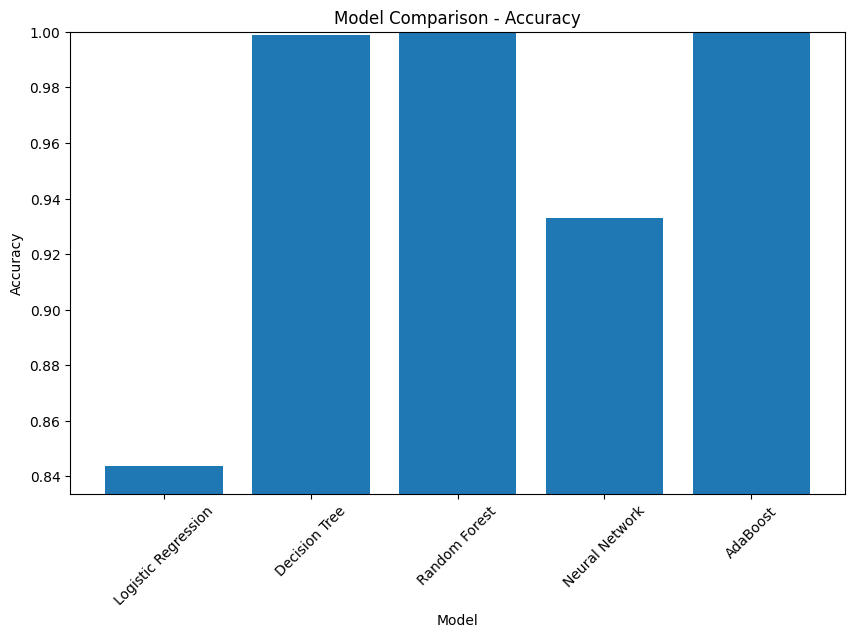

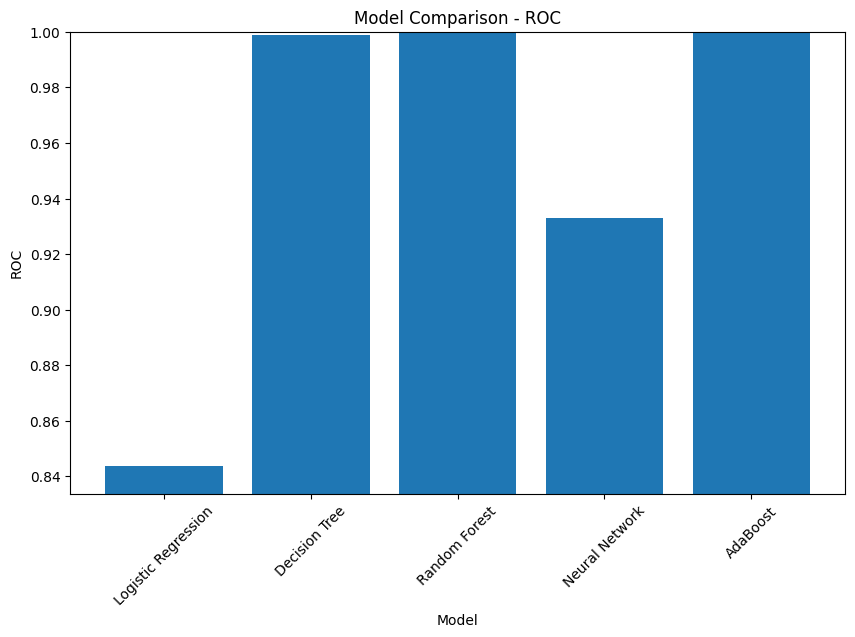

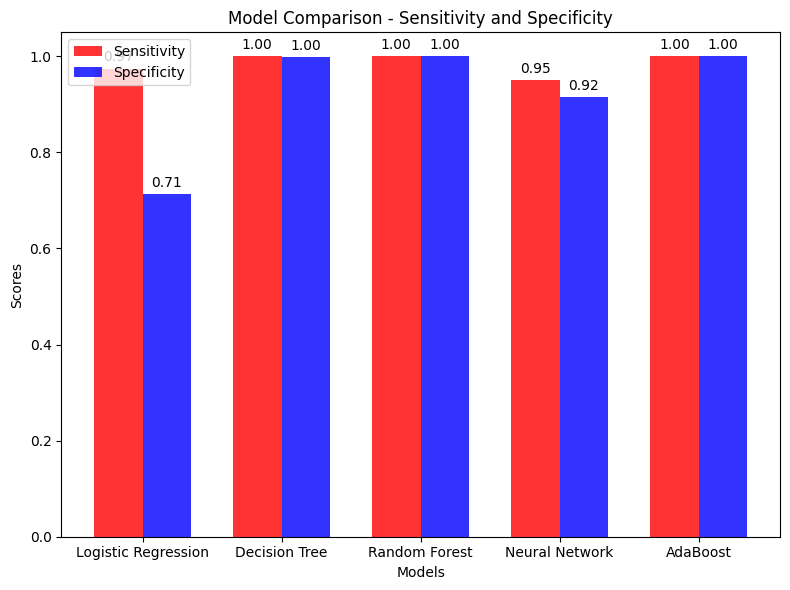

In [14]:
params = [log_reg_best_params, des_tree_best_params, rand_for_best_params, mlp_best_params, ada_boost_best_params]

final_scores = []

for (name, model, _), par in zip(algorithms, params):
    print(f"Fitting model {name} ...")
    model.set_params(**par)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"ROC AUC on testing data: {score:.4f}\n")
    print(f"Accuracy on testing data: {accuracy:.4f}\n")

    cm = confusion_matrix(y_test, y_pred)
    ((tn, fp), (fn, tp)) = confusion_matrix(y_test, y_pred)
    ((tnr,fpr),(fnr,tpr))= confusion_matrix(y_test, y_pred, 
            normalize='true')
    display(pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)']))
    final_scores.append((name, accuracy, score, cm))


model_names = [name for name, _, _, _ in final_scores]
accuracy_scores = [acc for _, acc, _, _ in final_scores]
roc_scores = [roc for _, _, roc, _ in final_scores]

cms = [cm for _, _, _, cm in final_scores]

plot_scores(model_names, accuracy_scores, 'Accuracy')
plot_scores(model_names, roc_scores, 'ROC')

plot_specificity_sensitivity(model_names, cms)

# Train final algorithm <a id="final-algorithm"/>

In [11]:
# os
import os

# data
import pandas as pd

# math
import numpy as np

# sklearn
from sklearn.utils import resample
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Prepare data for training and testing
# This assumes the data is placed in a subfolder 'data'
path = "./data" if os.path.exists("./data") else "."
data = pd.read_csv(os.path.join(path, "transactions.csv"))
X = data.drop("Class", axis=1)
y = data["Class"]
X_data = X.values
y_data = y.values

# oversample unbalanced data
X_oversampled, y_oversampled = resample(X_data[y_data == 1], y_data[y_data == 1], replace=True, n_samples=X_data[y_data == 0].shape[0], random_state=42)

X_balanced = np.vstack((X_data[y_data == 0], X_oversampled))
y_balanced = np.hstack((y_data[y_data == 0], y_oversampled))

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2,
                                                    random_state=1, stratify=y_balanced)


adaboost = AdaBoostClassifier()
ada_params = {'algorithm': 'SAMME.R', 'estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': 0}
adaboost.set_params(**ada_params)

adaboost.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=0)

In [12]:
# Testing and scoring

def leader_board_predict_fn(values):
    v = values
    try: 
        decision_function_values = adaboost.predict(v)
        return decision_function_values
    except Exception as e:
        print(str(e))
        raise e

In [13]:
decision_function_values = leader_board_predict_fn(X_test)
dataset_score = roc_auc_score(y_test, decision_function_values)

print("Score: ", dataset_score)

Score:  0.9734011555091576
